# **Project 3: Linear Classification**
By: Sheikh Islam, Wilson Jimenez, & Talha Akhlaq

In [ ]:
# Project 3: Linear Classification (Sheikh Islam, Wilson Jimenez, & Talha Akhlaq)

# Importing library
import os
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv, pinv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc

# Breast Cancer Wisconsin (Diagnostic) dataset loader
# Kaggle: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split  # Train/test split

Synthetic accuracy – Generative 93.50%, Logistic 94.00%


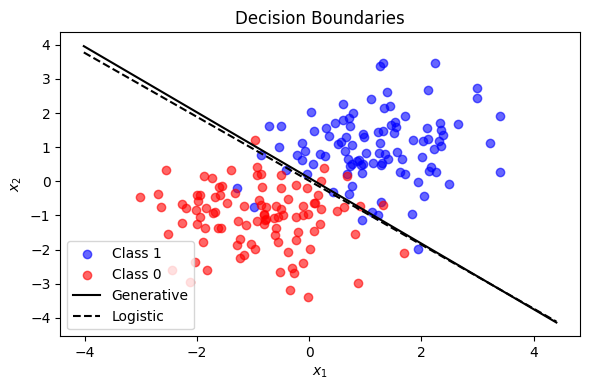

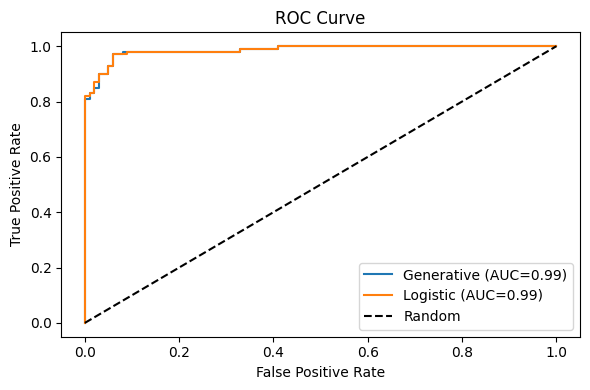

In [ ]:
# Determine output directory for saving figures
try:
    OUT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    OUT_DIR = os.getcwd()
os.makedirs(OUT_DIR, exist_ok=True)

#Creating definitions to make model work easier later. Each definition goes over

def fit_generative(X, y, eps=1e-6):
    #This function returns the weight vector and bias
    p1 = np.mean(y == 1)
    mu1 = X[y == 1].mean(axis=0)
    mu0 = X[y == 0].mean(axis=0)
    dev1 = X[y == 1] - mu1
    dev0 = X[y == 0] - mu0
    S = (dev1.T @ dev1 + dev0.T @ dev0) / X.shape[0]
    S += eps * np.eye(S.shape[0])
    S_inv = inv(S)
    w = S_inv @ (mu1 - mu0)
    w0 = (-0.5 * mu1.T @ S_inv @ mu1 + 0.5 * mu0.T @ S_inv @ mu0 + np.log(p1 / (1 - p1)))
    return w, w0

def fit_logistic(X, y, tol=1e-6, max_iter=100, reg=1e-4):
    w = np.zeros(X.shape[1])#Getting our weights set up
    for _ in range(max_iter):
        z = np.clip(X @ w, -250, 250)
        p = 1.0 / (1.0 + np.exp(-z))
        R = p * (1 - p)
        grad = X.T @ (p - y) + reg * w
        H = X.T @ (R[:, None] * X) + reg * np.eye(X.shape[1])  # This part is the Hessian
        try:
            delta = np.linalg.solve(H, grad) #updating delta
        except np.linalg.LinAlgError:
            delta = pinv(H) @ grad
        w -= delta #updating weights
        if np.linalg.norm(delta) < tol: #ending our loop of iterations if our desired tolerance of convergance is met
            break
    return w

def score(X, w, w0=None): #decision score
    return X @ w + (0.0 if w0 is None else w0)

def plot_boundary(X1, X0, wg, w0g, wl):
    #creating our scatter and decision boundary
    plt.figure(figsize=(6,4))
    #One for each of our classification classes
    plt.scatter(X1[:,0], X1[:,1], c='blue', alpha=0.6, label='Class 1')
    plt.scatter(X0[:,0], X0[:,1], c='red',  alpha=0.6, label='Class 0')
    xs = np.linspace(min(X1[:,0].min(), X0[:,0].min()) - 1, max(X1[:,0].max(), X0[:,0].max()) + 1, 200)
    ys_gen = -(w0g + wg[0]*xs) / wg[1]
    plt.plot(xs, ys_gen, 'k-',  label='Generative')

    b, w1, w2 = wl
    ys_log = -(b + w1*xs) / w2
    plt.plot(xs, ys_log, 'k--', label='Logistic')
    plt.xlabel('$x_1$'); plt.ylabel('$x_2$')
    plt.title('Decision Boundaries')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_roc(y, scores, labels):
    #Plotting ROC curve
    plt.figure(figsize=(6,4))
    for s, lab in zip(scores, labels):
        fpr, tpr, _ = roc_curve(y, s) #Computing the ROC points to them plot in next line
        plt.plot(fpr, tpr, label=f'{lab} (AUC={auc(fpr,tpr):.2f})')
    plt.plot([0,1],[0,1],'k--', label='Random') #baseline metric
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Synthetic experiment with generated data
np.random.seed(10)
N = 100
mu1 = np.array([1.,1.]); mu0 = np.array([-1.,-1.])
Sigma = np.eye(2) #covar matrix
X1 = np.random.multivariate_normal(mu1, Sigma, N) #samples
X0 = np.random.multivariate_normal(mu0, Sigma, N) #samples
#features and labels matrix
X  = np.vstack((X1, X0))
y  = np.hstack((np.ones(N), np.zeros(N)))

# Fit both classifiers
# Train LDA
wg, w0g = fit_generative(X, y)
# Train logistic
Xd = np.hstack((np.ones((2*N,1)), X))
wl = fit_logistic(Xd, y)

# Here determining the scores of the synthetic data and how well it fits
sg = score(X, wg, w0g)
sl = score(Xd, wl)
print(f"Synthetic accuracy – Generative {accuracy_score(y, sg>=0):.2%}, "
      f"Logistic {accuracy_score(y, sl>=0):.2%}")

# Plotting synthetics results
plot_boundary(X1, X0, wg, w0g, wl)  # Decision boundaries
plot_roc(y, [sg, sl], ['Generative','Logistic'])  # ROC curves

Breast-Cancer (2D) accuracy – Generative 87.72%, Logistic 87.13%


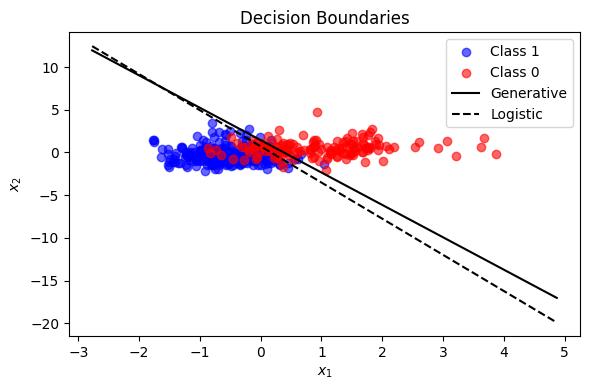

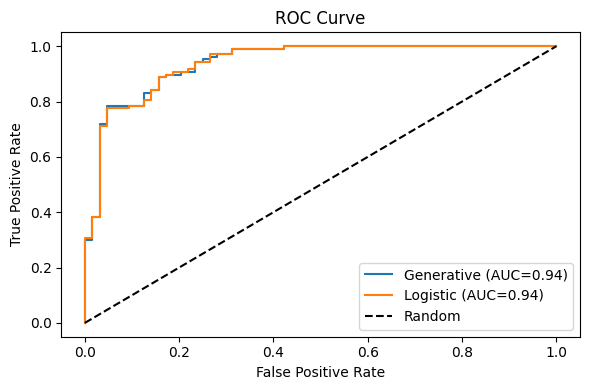

Breast-Cancer (30-D) accuracy – Generative 95.32%, Logistic 94.15%


In [ ]:
#STRETCH GOAL a lot of reused code from the project just needed to format the data properly. The more data you feed the better it classifies.

# Importing breast cancer data from kaggle
X_full, y_full = load_breast_cancer(return_X_y=True)
X2, y2 = X_full[:, :2], y_full

#Splitting data so we can use some to train and then text
Xtr2, Xte2, ytr2, yte2 = train_test_split(X2, y2, test_size=0.3, stratify=y2, random_state=0)
#Shapping data to be used
scaler2 = StandardScaler().fit(Xtr2)
Xtr2 = scaler2.transform(Xtr2)
Xte2 = scaler2.transform(Xte2)

#Same steps as in original project where we LDA train and logistic train
wg2, w0g2 = fit_generative(Xtr2, ytr2)
Xd2 = np.hstack((np.ones((Xtr2.shape[0],1)), Xtr2))
wl2 = fit_logistic(Xd2, ytr2)

#Once again now seeing the accuracies of the test by computing the scores
sg2 = score(Xte2, wg2, w0g2)
sl2 = score(np.hstack((np.ones((Xte2.shape[0],1)), Xte2)), wl2)
print(f"Breast-Cancer (2D) accuracy – Generative {accuracy_score(yte2, sg2>=0):.2%}, "
      f"Logistic {accuracy_score(yte2, sl2>=0):.2%}")

#Plotting
plot_boundary(Xtr2[ytr2==1], Xtr2[ytr2==0], wg2, w0g2, wl2)
plot_roc(yte2, [sg2, sl2], ['Generative','Logistic'])


# Taking the same steps below but just training it on all 30 data sets to show imporved accuracy as you can see in the results as it is fed more data.
# After training compute score for accuracy and improves by 7-8% compared to just two data sets
X_tr, X_te, y_tr, y_te = train_test_split(X_full, y_full, test_size=0.3, stratify=y_full, random_state=0)
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

wg_r, w0g_r = fit_generative(X_tr, y_tr)
sg_r     = score(X_te, wg_r, w0g_r)

X_tr_d = np.hstack((np.ones((X_tr.shape[0],1)), X_tr))
X_te_d = np.hstack((np.ones((X_te.shape[0],1)), X_te))
wl_r    = fit_logistic(X_tr_d, y_tr)
sl_r    = score(X_te_d, wl_r)

print(f"Breast-Cancer (30-D) accuracy – Generative {accuracy_score(y_te, sg_r>=0):.2%}, "
      f"Logistic {accuracy_score(y_te, sl_r>=0):.2%}")